# Neural & Behavioral Modeling - Week 10 (Examples)
by Tsung-Ren (Tren) Huang (trhuang@g.ntu.edu.tw)

In [ ]:
# Upgrade PyTorch if necessary:
# ! conda install pytorch torchvision -c pytorch

In [2]:
%config IPCompleter.greedy=True 
%matplotlib inline
import random
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [3]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
else:
    print('No GPU')

PyTorch version: 1.13.0
No GPU


## 1 NumPy vs. PyTorch
Here are examples modified from <a href="https://pytorch.org/tutorials/beginner/pytorch_with_examples.html">Learning PyTorch with Examples</a>.

<table>
   <th><img src="https://cdn2.iconfinder.com/data/icons/freecns-cumulus/32/519791-101_Warning-32.png" ></th>
   <th>PyTorch evolves quickly. Some codes may not work because of version incompatibility</a>.    </th>
</table>

Please check out https://pytorch.org/docs/versions.html for more API info. 

### 1.0 Quick Refresher on Backpropagation
Error of a neural network is 
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cb31622945129aee9708108af22230f7ca1362f7">

We can use <a href="https://medium.com/@ken90242/machine-learning%E5%AD%B8%E7%BF%92%E6%97%A5%E8%A8%98-coursera%E7%AF%87-week-1-3-parameter-9273f86c5613">gradient descent</a> to minimize this error:

$$W_{ij}=W_{ij}+\Delta W_{ij}=W_{ij}-\eta \frac{\partial E}{\partial W_{ij}}=W_{ij}-\eta \delta_j o_i$$

where the delta rule consists of an upstream activity term $o_i$ and a downstream error term $\delta_j$:

$$\delta_j=\begin{cases}
    (o_j-t_j)\frac{\partial\phi(o_j)}{\partial o_j}  &  \text{if j is an output neuron}\\
    (\sum_k{W_{jk}\delta_k})\frac{\partial\phi(o_j)}{\partial o_j}  &  \text{if j is an inner neuron}
   \end{cases}$$
      
When the activation function $\phi(x)=1/(1+exp(-x))$ (i.e., sigmoid), then:

$$\delta_j=\begin{cases}
    (o_j-t_j)o_j(1-o_j)  &  \text{if j is an output neuron}\\
    (\sum_k{W_{jk}\delta_k})o_j(1-o_j)  &  \text{if j is an inner neuron}
   \end{cases}$$
   
   
When the activation function $\phi(x)=x$ (i.e., linear), then: 

$$\delta_j=\begin{cases}
    (o_j-t_j)  &  \text{if j is an output neuron}\\
    \sum_k{W_{jk}\delta_k}  &  \text{if j is an inner neuron}
   \end{cases}$$

When the activation function $\phi(x)=max(0,x)$ (i.e., ReLU), then:
 
 $$\delta_j=\begin{cases}
    (o_j-t_j)  &  \text{if } o_j>0 \text{ & j is an output neuron}\\
    \sum_k{W_{jk}\delta_k}  & \text{if } o_j>0 \text{ & j is an inner neuron}\\
    0 & \text{if } o_j\leq 0
   \end{cases}$$
   
    


### 1.1 NumPy

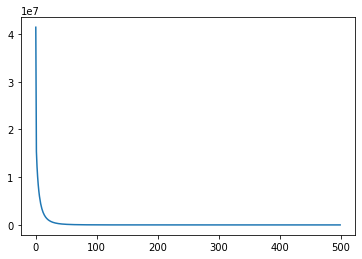

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
loss_history=[]

for i in range(500):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred - y).sum()
    loss_history.append(loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = y_pred - y
    grad_w2 = h_relu.T.dot(grad_y_pred) # h_relu=activation of layer 2; dReLU(h)/dh=1 for h>0
    grad_h_relu = grad_y_pred.dot(w2.T) # computing delta on layer 2 for the learning of w1
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0 # dReLU/dt=0 for h<0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

plot(loss_history);

### 1.2 PyTorch w/ Manual Differentiation

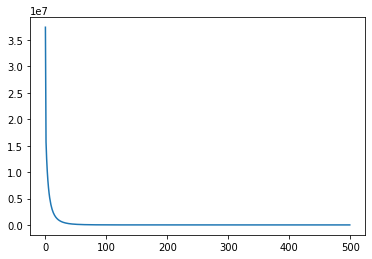

In [ ]:
dtype = t.float # https://pytorch.org/docs/stable/tensors.html
device = t.device("cuda:0") #t.device("cpu")

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = t.randn(N, D_in, device=device, dtype=dtype)
y = t.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = t.randn(D_in, H, device=device, dtype=dtype)
w2 = t.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
loss_history=[]

for i in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    loss_history.append(loss.item())

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = y_pred - y
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    
plot(loss_history);

In [ ]:
type(loss)

float

### 1.3 PyTorch w/ Automatic Differentiation (autograd)

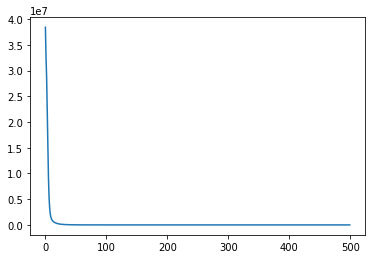

In [ ]:
dtype = t.float
device = t.device("cuda:0")# t.device("cpu")

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = t.randn(N, D_in, device=device, dtype=dtype)
y = t.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = t.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = t.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
loss_history=[]

for i in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the a scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    loss_history.append(loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # torch.no_grad() is a context-manager that disabled gradient calculation.
    # Disabling gradient calculation is useful for inference, when you are sure
    # that you will not call Tensor.backward(). It will reduce memory
    # consumption for computations that would otherwise have requires_grad=True.
    # In this mode, the result of every computation will have
    # requires_grad=False, even when the inputs have requires_grad=True.
    with t.no_grad():
      w1 -= learning_rate * w1.grad
      w2 -= learning_rate * w2.grad

      # Manually zero the gradients after updating weights, otherwise they keep accumulating
      w1.grad.zero_()
      w2.grad.zero_()

plot(loss_history);

## 2 Computing Gradients

### 2.1 Numerical Differentiation in NumPy

In [ ]:
# Supporting functions: -----------------------
def numerical_gradient(f, X):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(X)
    for idx in range(X.size):
        tmp_val = X[idx]
        X[idx] = float(tmp_val) + h
        fxh1 = f(X) # f(x+h)
        X[idx] = tmp_val - h
        fxh2 = f(X) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        X[idx] = tmp_val 
    return grad

def y(X):
    return X[0]*X[1]+X[2] #w*x+b
#----------------------------------------------

print(y(np.array([1,2,3]))) # y=wx+b=1*x+3
print(numerical_gradient(y,np.array([1.,2.,3.]))) #(dy/dw|w=1, dy/dx|x=2, dy/db|b=3)

5
[2. 1. 1.]


### 2.2 Automatic Differentiation in PyTorch (autograd)

#### 2.2.1 Built-in functions/operations

In [6]:
# Create tensors:
w=t.tensor(1.,requires_grad=True)
x=t.tensor(2.,requires_grad=True)
b=t.tensor(3.,requires_grad=True)


# Build a two-node computational graph (* followed by +):
y=w*x+b # y=1*x+3
print(y)

# Examine the computational graph:
print('x:',x.requires_grad,x.is_leaf,x.grad_fn)
print('y:',y.requires_grad,y.is_leaf,y.grad_fn, y.grad_fn.next_functions)

# Compute gradients:
y.backward()
print('dy/dw|w=1:',w.grad)
print('dy/dx|x=2:',x.grad)
print('dy/db|b=3:',b.grad)

tensor(5., grad_fn=<AddBackward0>)
x: True True None
y: True False <AddBackward0 object at 0x118d2aa30> ((<MulBackward0 object at 0x103d162b0>, 0), (<AccumulateGrad object at 0x103dd5850>, 0))
dy/dw|w=1: tensor(2.)
dy/dx|x=2: tensor(1.)
dy/db|b=3: tensor(1.)


## 3 Better Modularization

### 3.1 NumPy
These are programs modified from <a href="http://www.books.com.tw/products/0010761759">the textbook</a>.

In [ ]:
# Activation & error functions:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))    
    
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) 
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1) # one-hot coding
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
# Layers:

class Identity: #x
    def forward(self,x):
        return x
    
    def backward(self,dout):
        return dout
    
class Relu: # max(0,x)
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid: # 1/(1+exp(-x))
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine: # Wx+b
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None 
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # one-hot vector
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None  

        self.running_mean = running_mean
        self.running_var = running_var  
        
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

In [ ]:
# Optimizers:

class SGD:

    """（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]
            
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [11]:
# Networks:
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 1):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = Identity() # for regression
        #self.lastLayer = SoftmaxWithLoss() # for classification

        
    def predict(self, x):
        for layer in self.layers.values(): # up to the second last layer
            x = layer.forward(x)
        y=self.lastLayer.forward(x) # pass to the final layer
        return y
        
    def loss(self, x, t):
        y = self.predict(x) 
        return mean_squared_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
                
    def gradient(self, x, t):
        # forward
        y = self.predict(x)

        # backward
        dout = y-t
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

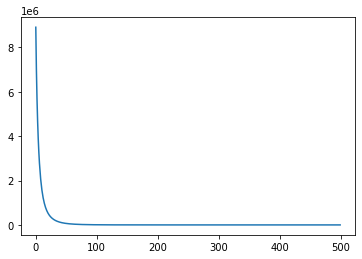

In [12]:
# Putting everything together:

# ====================================================
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

learning_rate = 1e-6
optimizer = SGD(lr=learning_rate)
#optimizer = Momentum(lr=learning_rate)
loss_history=[]
# ====================================================

model=TwoLayerNet(input_size=D_in, hidden_size=H, output_size=D_out)

for i in range(500):
    grads=model.gradient(x,y)
    optimizer.update(model.params,grads)
    loss_history.append(model.loss(x,y))
    
plot(loss_history);

### 3.2  PyTorch (nn module)

 #### 3.2.1 Automatic weight-updating (optim module)

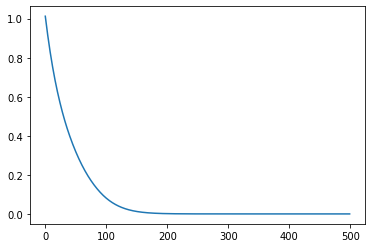

In [6]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = t.randn(N, D_in)
y = t.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    t.nn.ReLU(),
    t.nn.Linear(H, D_out),
)

loss_fn = t.nn.MSELoss()

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
loss_history=[]

for i in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    loss_history.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    

plot(loss_history);

## 4 Real-world Applications

### 4.0 MNIST dataset
<img src="https://cdn-images-1.medium.com/max/880/1*xKvP4fvSIR069GDXqy8uZg.png" width=50%>

In [8]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x7fda97de1390>)

In [9]:
# Load the dataset:
import pickle, gzip
f = gzip.open('mnist.pkl.gz','rb')
train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
f.close()
x_train,y_train=train_set[0],train_set[1]
x_valid,y_valid=valid_set[0],valid_set[1]
x_test,y_test=test_set[0],test_set[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\>'
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: invalid escape sequence '\?'
  after removing the cwd from sys.path.


(50000, 784) (50000,) (10000, 784) (10000,)
0.0 0.99609375 0 9


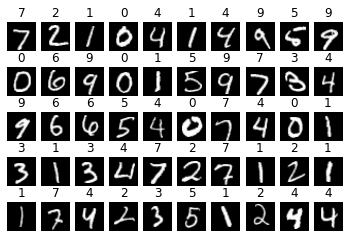

In [26]:
# Examine the dataset:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(y_test[i]));
    axis('off')

### 4.1 Classfiy MNIST in NumpPy

In [27]:
# Network:
class MultiLayerNetExtend:    
    "Weiht Decay + Dropout + Batch Normalization"
    
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ratio = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        self.__init_weight(weight_init_std)

        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):

        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # for ReLu
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # for Sigmoid
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [28]:
# Training the network:
max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
weight_init_std = 0.01

model=MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100], output_size=10,
                        weight_init_std=weight_init_std, use_batchnorm=True, use_dropout=True)

optimizer = SGD(lr=learning_rate)
train_acc_list = []
    
iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0
    
for i in range(100000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    grads = model.gradient(x_batch, y_batch)
    optimizer.update(model.params, grads)
    if i % iter_per_epoch == 0:
        train_acc = model.accuracy(x_train, y_train)
        train_acc_list.append(train_acc)
        print("epoch:" + str(epoch_cnt) + " | " + str(train_acc))
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break    

epoch:0 | 0.11538
epoch:1 | 0.82374
epoch:2 | 0.91128
epoch:3 | 0.92804
epoch:4 | 0.93568
epoch:5 | 0.94178
epoch:6 | 0.94634
epoch:7 | 0.9501
epoch:8 | 0.95356
epoch:9 | 0.9562
epoch:10 | 0.95736
epoch:11 | 0.95938
epoch:12 | 0.96012
epoch:13 | 0.96254
epoch:14 | 0.96448
epoch:15 | 0.96534
epoch:16 | 0.96526
epoch:17 | 0.96746
epoch:18 | 0.96742
epoch:19 | 0.96912


### 4.2 Classfiy MNIST in PyTorch

In [11]:
# Transform NumPy arrays to PyTorch tensors:
use_cuda=t.cuda.is_available()

X_train=t.from_numpy(x_train)
Y_train=t.from_numpy(y_train)
X_test=t.from_numpy(x_test)
Y_test=t.from_numpy(y_test)

if(use_cuda):
    X_train=X_train.cuda()
    Y_train=Y_train.cuda()
    X_test=X_test.cuda()
    Y_test=Y_test.cuda()

In [16]:
D_in,H,D_out=784,100,10

# Training the network:
model = t.nn.Sequential(
    t.nn.Linear(D_in, H),
    #t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    #t.nn.Linear(H, H),
    #t.nn.BatchNorm1d(H),
    #ct.nn.ReLU(),
    #t.nn.Dropout(p=0.5),
    t.nn.Linear(H, D_out),
    t.nn.Softmax()
)

loss_fn = t.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = t.optim.Adam(model.parameters(), lr=learning_rate) #https://pytorch.org/docs/stable/optim.html

if(use_cuda):
    model=model.cuda()
    loss_fn=loss_fn.cuda()
    
for i in range(1000):
    # Forward pass:
    Y_pred = model(X_train)

    loss = loss_fn(Y_pred, Y_train)
    
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass:
    loss.backward()

    # Update the weights using gradient descent:
    optimizer.step()
    
    # Check training accuracy:
    if i % 50 == 0:
        Y_pred = model(X_train) # Y_pred.shape=[50000,10]
        Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
        print('epoch ',i,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])

epoch  0 : 0.08092
epoch  50 : 0.37468
epoch  100 : 0.60062
epoch  150 : 0.64842
epoch  200 : 0.65462
epoch  250 : 0.7158
epoch  300 : 0.73332
epoch  350 : 0.80154
epoch  400 : 0.8125
epoch  450 : 0.81876
epoch  500 : 0.8228
epoch  550 : 0.8269
epoch  600 : 0.82996
epoch  650 : 0.83224
epoch  700 : 0.83424
epoch  750 : 0.8361
epoch  800 : 0.8379
epoch  850 : 0.83984
epoch  900 : 0.84122
epoch  950 : 0.84258


/raid/opt/hpc/anaconda/python3/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy on all testing samples: 0.8474
Accuracy on the first 50 testing samples: 0.86
Correct answers:
 [[7 2 1 0 4 1 4 9 5 9]
 [0 6 9 0 1 5 9 7 3 4]
 [9 6 6 5 4 0 7 4 0 1]
 [3 1 3 4 7 2 7 1 2 1]
 [1 7 4 2 3 5 1 2 4 4]]


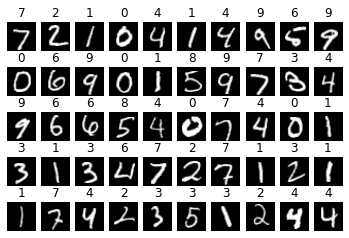

In [ ]:
# Testing the network:
Y_pred = model(X_test) # Y_pred.shape=[50000,10]
Y_pred = t.max(Y_pred,1)[1] # Y_pred.shape=[50000]
test_acc=(Y_pred==Y_test).sum().item()/Y_test.shape[0]
print('Accuracy on all testing samples:',test_acc)

# Visualize results of the first 50 testing samples:
Y_pred = model(X_test[0:50,]) # Y_pred.shape=[50000,10]
Y_pred = t.max(Y_pred[0:50],1)[1] # Y_pred.shape=[50000]
test_acc=(Y_pred==Y_test[0:50]).sum().item()/50
print('Accuracy on the first 50 testing samples:',test_acc)
print('Correct answers:\n',y_test[0:50].reshape([5,10]))

for i in range(50):
    subplot(5,10,i+1)
    imshow(x_test[i].reshape([28,28]),cmap='gray');
    title(str(Y_pred[i].item()));
    axis('off')